In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import math
from sklearn.metrics import mean_squared_error

In [2]:
path=r'F:\Bosch Project\2nd test\2nd_test\2nd_test'

In [3]:
#bearing_1
feature_matrix=pd.DataFrame()
individual_features=np.zeros((1,4))
bearing_no=0
for filename in os.listdir(path):
    
    dataset=pd.read_csv(os.path.join(path,filename),sep='\t',header=None)
    bearing1=np.array(dataset.iloc[:,0])
    def kurtosis(x):
        n=len(x)
        s1=np.sum((x-np.mean(x))**4)/n
        s2=np.std(x,ddof=1)**4
        return s1/s2 - 3
    individual_features[0,0]=np.max(bearing1)
    individual_features[0,1]=np.std(bearing1,ddof=1)
    individual_features[0,2] = kurtosis(bearing1)
    individual_features[0,3] = np.sqrt(np.mean(bearing1 ** 2))
    features=pd.DataFrame(individual_features)
    features.index=[filename[:-3]]
    feature_matrix=feature_matrix.append(features)

In [4]:
feature_matrix.columns=['Max','Std','Kurtosis','RMS']  
feature_matrix.index=pd.to_datetime(feature_matrix.index,format='%Y.%m.%d.%H.%M')

In [5]:
from statsmodels.nonparametric.kernel_regression import KernelReg
n = feature_matrix.shape[0]
kde1= KernelReg(endog=feature_matrix['Max'], exog=np.arange(n), var_type='c', bw=[34])
estimator1 = kde1.fit(np.arange(n))

In [6]:
kde2 = KernelReg(endog=feature_matrix['Std'], exog=np.arange(n), var_type='c', bw=[34])
estimator2 = kde2.fit(np.arange(n))

In [7]:
kde3 = KernelReg(endog=feature_matrix['Kurtosis'], exog=np.arange(n), var_type='c', bw=[34])
estimator3 = kde3.fit(np.arange(n))

In [8]:
kde4= KernelReg(endog=feature_matrix['RMS'], exog=np.arange(n), var_type='c', bw=[34])
estimator4 = kde4.fit(np.arange(n))

In [9]:
estimator1= np.reshape(estimator1[0],n)
estimator2= np.reshape(estimator2[0],n)
estimator3= np.reshape(estimator3[0],n)
estimator4= np.reshape(estimator4[0],n)

Text(0.5, 1.0, 'Maximum')

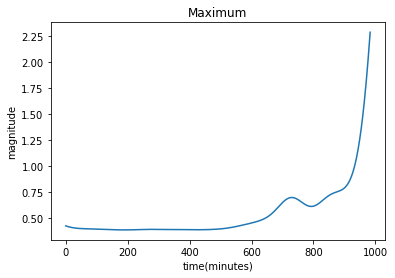

In [14]:
plt.plot(estimator1)
plt.xlabel('time(minutes)')
plt.ylabel('magnitude')
plt.title('Maximum')

Text(0.5, 1.0, 'Standard Deviation')

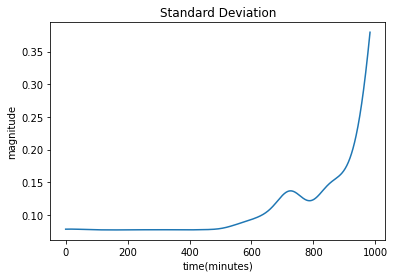

In [15]:
plt.plot(estimator2)
plt.xlabel('time(minutes)')
plt.ylabel('magnitude')
plt.title('Standard Deviation')

Text(0.5, 1.0, 'Kurtosis')

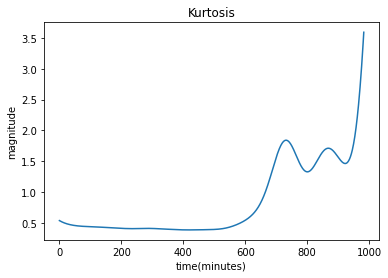

In [18]:
plt.plot(estimator3)
plt.xlabel('time(minutes)')
plt.ylabel('magnitude')
plt.title('Kurtosis')

Text(0.5, 1.0, 'RMS')

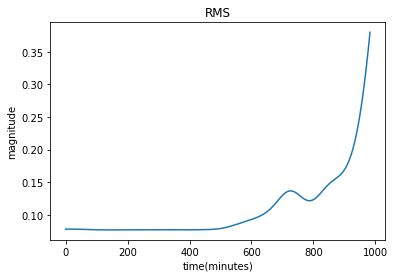

In [36]:
plt.plot(estimator4)
plt.xlabel('time(minutes)')
plt.ylabel('magnitude')
plt.title('RMS')

In [19]:
estimator1=pd.DataFrame(estimator1)
estimator2=pd.DataFrame(estimator2)
estimator3=pd.DataFrame(estimator3)
estimator4=pd.DataFrame(estimator4)

In [20]:
estimator1=pd.concat([estimator1,estimator2],axis=1)

In [21]:
estimator1=pd.concat([estimator1,estimator3],axis=1)

In [22]:
estimator1=pd.concat([estimator1,estimator4],axis=1)

In [23]:
estimator_features=estimator1

In [24]:
estimator_features.columns=['Max','Std','Kurtosis','RMS']  
estimator_features.index=pd.to_datetime(feature_matrix.index,format='%Y.%m.%d.%H.%M')

In [25]:
time_stamp=pd.DataFrame()
t=pd.DataFrame()
c=glob.glob(r'F:\Bosch Project\2nd test\2nd_test\2nd_test\*')
files=len(c)
for i in range(files):
    time=i*10
    t.loc[0,0]=time
    time_stamp=time_stamp.append(t)

In [26]:
smoothingdata=pd.DataFrame()
smoothingdata.insert(loc=0,column='time',value=time_stamp)
smoothingdata.insert(loc=1,column='Max',value=np.array(estimator_features['Max']))
smoothingdata.insert(loc=2,column='Std',value=np.array(estimator_features['Std']))
smoothingdata.insert(loc=3,column='Kurtosis',value=np.array(estimator_features['Kurtosis']))
smoothingdata.insert(loc=4,column='RMS',value=np.array(estimator_features['RMS']))

In [27]:
smoothingdata

,time,Max,Std,Kurtosis,RMS
0,0.0,0.421397,0.078015,0.540487,0.078083
0,10.0,0.420336,0.078030,0.537579,0.078095
0,20.0,0.419305,0.078043,0.534746,0.078107
0,30.0,0.418302,0.078055,0.531985,0.078118
0,40.0,0.417328,0.078067,0.529295,0.078127
...,...,...,...,...,...
0,9790.0,2.126262,0.361064,3.261836,0.361148
0,9800.0,2.165659,0.365661,3.340790,0.365749
0,9810.0,2.205706,0.370305,3.421733,0.370397
0,9820.0,2.246399,0.374995,3.504670,0.375090


In [28]:
smoothingdata.set_index('time',inplace=True)

In [29]:
from sklearn.preprocessing import MinMaxScaler
le=MinMaxScaler()
smoothingdata=le.fit_transform(smoothingdata)
smoothingdata=pd.DataFrame(smoothingdata)

In [30]:
train_size = int(len(smoothingdata) * 0.9)
validation_size = len(smoothingdata) - train_size
train, validation = np.array(smoothingdata)[0:train_size,:], np.array(smoothingdata)[train_size:len(smoothingdata),:]

In [31]:
x_train = []
x_validation=[]
y_train = []
y_validation=[]
target= 1 
past_features= 7
for i in range(past_features, len(train) - target +1):
    x_train.append(train[i - past_features:i, 0:(train.shape[1])])
    y_train.append(train[i + target - 1:i + target, 3])
    
for i in range(past_features, len(validation) - target +1):
    x_validation.append(validation[i - past_features:i, 0:(validation.shape[1])])
    y_validation.append(validation[i + target - 1:i + target, 3])

In [32]:
x_train=np.array(x_train)
y_train=np.array(y_train)
x_validation=np.array(x_validation)
y_validation=np.array(y_validation)

In [33]:
x_train.shape

(878, 7, 4)

In [35]:
validation.shape

(99, 4)

In [24]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,GRU,SimpleRNN,Bidirectional

In [25]:
model=Sequential()
model.add(LSTM(100,input_shape=(x_train.shape[1], x_train.shape[2]),kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))
model.compile(optimizer='adam', loss='mse')
callback=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)

In [26]:
history=model.fit(x_train, y_train,validation_data=(x_validation,y_validation),epochs=100, batch_size=16, callbacks=[callback],verbose=1)

Epoch 1/100
55/55 [==============================] - 4s 23ms/step - loss: 0.0104 - val_loss: 0.0819
Epoch 2/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0039 - val_loss: 0.0618
Epoch 3/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0560
Epoch 4/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0458
Epoch 5/100
55/55 [==============================] - 1s 13ms/step - loss: 0.0010 - val_loss: 0.0504
Epoch 6/100
55/55 [==============================] - 1s 13ms/step - loss: 9.8374e-04 - val_loss: 0.0333
Epoch 7/100
55/55 [==============================] - 1s 14ms/step - loss: 8.5548e-04 - val_loss: 0.0520
Epoch 8/100
55/55 [==============================] - 1s 14ms/step - loss: 7.9753e-04 - val_loss: 0.0268
Epoch 9/100
55/55 [==============================] - 1s 12ms/step - loss: 7.7961e-04 - val_loss: 0.0250
Epoch 10/100
55/55 [==============================] - 1s 12ms/step - loss: 6.4225e-0

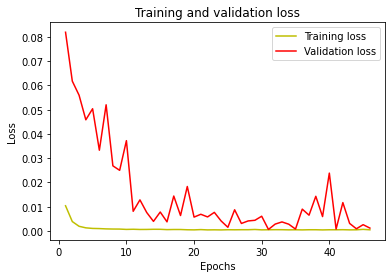

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [28]:
####RNN

In [251]:
model1=Sequential()
model1.add(SimpleRNN(50,input_shape=(x_train.shape[1], x_train.shape[2]),kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu',return_sequences=True))
model1.add(Dropout(0.4))
model1.add(SimpleRNN(16,kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(16))
model1.add(Dropout(0.4))
model1.add(Dense(1,activation='linear'))
model1.compile(optimizer='adam', loss='mse')
callback=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)

In [252]:
history1=model1.fit(x_train, y_train,validation_data=(x_validation,y_validation),epochs=100, batch_size=16, callbacks=[callback],verbose=1)

Epoch 1/100
55/55 [==============================] - 4s 18ms/step - loss: 0.0096 - val_loss: 0.1308
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0060 - val_loss: 0.0980
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0547
Epoch 4/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0456
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0524
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0422
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0583
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0394
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0347
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0410
Epoch 11

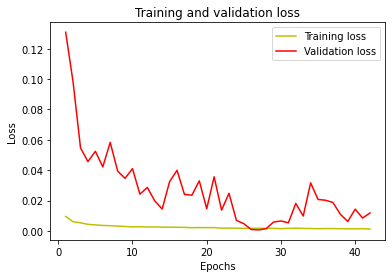

In [253]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [254]:
###Bidirectional LSTM

In [177]:
model2=Sequential()
model2.add(Bidirectional(LSTM(100,input_shape=(x_train.shape[1], x_train.shape[2]),kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu',return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(32,kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu')))
model2.add(Dropout(0.2))
model2.add(Dense(16,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='linear'))
model2.compile(optimizer='adam',loss='mse')
callback=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)

In [178]:
history2=model2.fit(x_train, y_train,validation_data=(x_validation,y_validation),epochs=100, batch_size=16, callbacks=[callback],verbose=1)

Epoch 1/100
55/55 [==============================] - 11s 43ms/step - loss: 0.0231 - val_loss: 0.0334
Epoch 2/100
55/55 [==============================] - 1s 21ms/step - loss: 0.0069 - val_loss: 0.0449
Epoch 3/100
55/55 [==============================] - 1s 22ms/step - loss: 0.0028 - val_loss: 0.0302
Epoch 4/100
55/55 [==============================] - 1s 21ms/step - loss: 0.0017 - val_loss: 0.0362
Epoch 5/100
55/55 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 0.0320
Epoch 6/100
55/55 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 0.0248
Epoch 7/100
55/55 [==============================] - 1s 21ms/step - loss: 9.9381e-04 - val_loss: 0.0277
Epoch 8/100
55/55 [==============================] - 1s 21ms/step - loss: 7.7250e-04 - val_loss: 0.0243
Epoch 9/100
55/55 [==============================] - 1s 21ms/step - loss: 7.6625e-04 - val_loss: 0.0227
Epoch 10/100
55/55 [==============================] - 1s 22ms/step - loss: 6.9563e-04 -

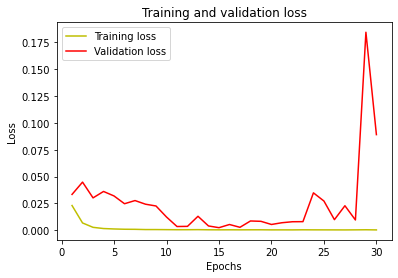

In [179]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [180]:
####GRU

In [181]:
model3=Sequential()
model3.add(GRU(100,input_shape=(x_train.shape[1], x_train.shape[2]),kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu',return_sequences=True))
model3.add(Dropout(0.2))
model3.add(GRU(32,kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001),activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(16))
model3.add(Dropout(0.2))
model3.add(Dense(1,activation='linear'))
model3.compile(optimizer='adam', loss='mse')
callback=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)

In [182]:
history3=model3.fit(x_train, y_train,validation_data=(x_validation,y_validation),epochs=100, batch_size=16, callbacks=[callback],verbose=1)

Epoch 1/100
55/55 [==============================] - 6s 25ms/step - loss: 0.0086 - val_loss: 0.0152
Epoch 2/100
55/55 [==============================] - 1s 14ms/step - loss: 0.0038 - val_loss: 0.0166
Epoch 3/100
55/55 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0159
Epoch 4/100
55/55 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0131
Epoch 5/100
55/55 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0151
Epoch 6/100
55/55 [==============================] - 1s 15ms/step - loss: 0.0011 - val_loss: 0.0162
Epoch 7/100
55/55 [==============================] - 1s 15ms/step - loss: 8.1786e-04 - val_loss: 0.0153
Epoch 8/100
55/55 [==============================] - 1s 16ms/step - loss: 8.1286e-04 - val_loss: 0.0149
Epoch 9/100
55/55 [==============================] - ETA: 0s - loss: 8.0450e-0 - 1s 16ms/step - loss: 8.0946e-04 - val_loss: 0.0262
Epoch 10/100
55/55 [==============================] - 1s 14m

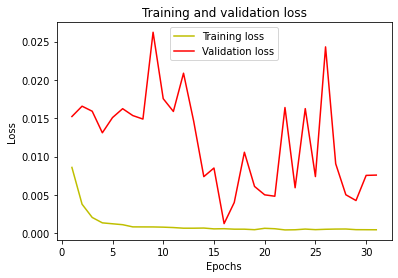

In [183]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [184]:
prediction0 = model.predict(x_train)
prediction1 = model1.predict(x_train)
prediction2 = model2.predict(x_train)
prediction3 = model3.predict(x_train)

In [185]:
prediction=prediction0+prediction1+prediction2+prediction3

In [186]:
prediction=prediction/4

In [29]:
train_prediction=model.predict(x_train)
validation_prediction=model.predict(x_validation)

In [30]:
train1=pd.DataFrame(train)
validation1=pd.DataFrame(validation)
train_features=np.array(train1.iloc[:,0:4])
validation_features=np.array(validation1.iloc[:,0:4])

In [31]:
train_inverse_data=pd.concat([pd.DataFrame(train_features[past_features:,0:3]),pd.DataFrame(train_prediction)],axis=1)
validation_inverse_data=pd.concat([pd.DataFrame(validation_features[past_features:,0:3]),pd.DataFrame(validation_prediction)],axis=1)

In [32]:
train_transformed_data = le.inverse_transform(train_inverse_data)
train_transformed_data =pd.DataFrame(train_transformed_data)
validation_transformed_data = le.inverse_transform(validation_inverse_data)
validation_transformed_data =pd.DataFrame(validation_transformed_data)

In [33]:
train_transformed_data.columns=['Max','Std','Kurtosis','RMS_predicted']
validation_transformed_data.columns=['Max','Std','Kurtosis','RMS_predicted']

In [34]:
main_smoothingdata = le.inverse_transform(smoothingdata)
main_smoothingdata=pd.DataFrame(main_smoothingdata)

In [35]:
main_smoothingdata.columns=['Max','Std','Kurtosis','RMS']

In [36]:
from sklearn.metrics import mean_squared_error
import math
trainScore = math.sqrt(mean_squared_error(main_smoothingdata['RMS'][past_features:885],train_transformed_data['RMS_predicted']) )
print('Train Score: %.4f RMSE' % (trainScore))

Train Score: 0.0017 RMSE


In [37]:
validationScore = math.sqrt(mean_squared_error(main_smoothingdata['RMS'][past_features+885:],validation_transformed_data['RMS_predicted'] ))
print('Validation Score: %.4f RMSE' % (validationScore))

Validation Score: 0.0101 RMSE


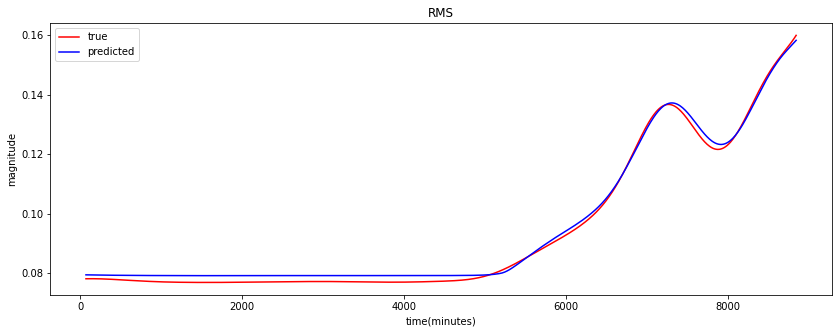

In [39]:
plt.figure(figsize=(14, 5))
plt.plot(np.array(time_stamp[past_features:len(train)]),main_smoothingdata['RMS'][past_features:885],'r',label='true')
plt.plot(np.array(time_stamp[past_features:len(train)]),train_transformed_data['RMS_predicted'],'b',label='predicted')
plt.legend(loc="upper left")
plt.ylabel('magnitude')
plt.xlabel('time(minutes)')
plt.title('RMS')
plt.show()

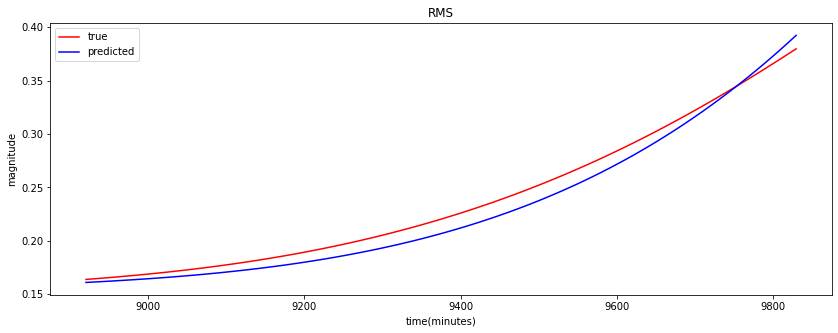

In [40]:
plt.figure(figsize=(14, 5))
plt.plot(np.array(time_stamp[len(train)+past_features:len(smoothingdata)]),main_smoothingdata['RMS'][past_features+885:],'r',label="true")
plt.plot(np.array(time_stamp[len(train)+past_features:len(smoothingdata)]),validation_transformed_data['RMS_predicted'],'b',label="predicted")
plt.legend(loc="upper left")
plt.ylabel('magnitude')
plt.xlabel('time(minutes)')
plt.title('RMS')
plt.show()

In [198]:
###testing

In [41]:
#bearing_2
test_feature_matrix=pd.DataFrame()
test_individual_features=np.zeros((1,4))
bearing_no=2
for filename in os.listdir(path):
    
    dataset=pd.read_csv(os.path.join(path,filename),sep='\t',header=None)
    bearing2=np.array(dataset.iloc[:,1])
    def kurtosis(x):
        n=len(x)
        s1=np.sum((x-np.mean(x))**4)/n
        s2=np.std(x,ddof=1)**4
        return s1/s2 - 3
    test_individual_features[0,0]=np.max(bearing2)
    test_individual_features[0,1]=np.std(bearing2,ddof=1)
    test_individual_features[0,2] = kurtosis(bearing2)
    test_individual_features[0,3] = np.sqrt(np.mean(bearing2 ** 2))
    test_features=pd.DataFrame(test_individual_features)
    test_features.index=[filename[:-3]]
    test_feature_matrix=test_feature_matrix.append(test_features)

In [42]:
test_feature_matrix.columns=['Max','Std','Kurtosis','RMS']  
test_feature_matrix.index=pd.to_datetime(feature_matrix.index,format='%Y.%m.%d.%H.%M')

In [43]:
from statsmodels.nonparametric.kernel_regression import KernelReg
n1 = test_feature_matrix.shape[0]
test_kde1= KernelReg(endog=test_feature_matrix['Max'], exog=np.arange(n1), var_type='c', bw=[34])
test_estimator1 = test_kde1.fit(np.arange(n1))

In [44]:
test_kde2 = KernelReg(endog=test_feature_matrix['Std'], exog=np.arange(n1), var_type='c', bw=[34])
test_estimator2 = test_kde2.fit(np.arange(n1))

In [45]:
test_feature_matrix['Kurtosis'][-4:]=0

In [46]:


test_kde4= KernelReg(endog=test_feature_matrix['RMS'], exog=np.arange(n1), var_type='c', bw=[34])
test_estimator4 = test_kde4.fit(np.arange(n1))

In [47]:
test_estimator1= np.reshape(test_estimator1[0],n1)
test_estimator2= np.reshape(test_estimator2[0],n1)

test_estimator4= np.reshape(test_estimator4[0],n1)

In [48]:
test_estimator1=pd.DataFrame(test_estimator1)
test_estimator2=pd.DataFrame(test_estimator2)
test_estimator3=pd.DataFrame(np.array(test_feature_matrix['Kurtosis']))
test_estimator4=pd.DataFrame(test_estimator4)

In [49]:
test_estimator1=pd.concat([test_estimator1,test_estimator2],axis=1)

In [50]:
test_estimator1=pd.concat([test_estimator1,test_estimator3],axis=1)

In [51]:
test_estimator1=pd.concat([test_estimator1,test_estimator4],axis=1)

In [52]:
test_estimator1

,0,0,0,0
0,0.475767,0.094075,0.506458,0.094144
1,0.475440,0.094125,0.252696,0.094191
2,0.475125,0.094174,0.310466,0.094238
3,0.474821,0.094221,0.235025,0.094283
4,0.474529,0.094268,0.225994,0.094327
...,...,...,...,...
979,0.634300,0.154592,2.452206,0.154738
980,0.636859,0.154972,0.000000,0.155124
981,0.639426,0.155339,0.000000,0.155497
982,0.642001,0.155693,0.000000,0.155857


In [53]:
test_estimator_features=test_estimator1

test_estimator_features.columns=['Max','Std','Kurtosis','RMS']  
test_estimator_features.index=pd.to_datetime(test_feature_matrix.index,format='%Y.%m.%d.%H.%M')

In [54]:
validate_test_time_stamp=pd.DataFrame()
validate_test_t=pd.DataFrame()
c2=glob.glob(r'F:\Bosch Project\2nd test\2nd_test\2nd_test\*')
files=len(c)
for i in range(files):
    validate_test_time=i*10
    validate_test_t.loc[0,0]=validate_test_time
    validate_test_time_stamp=validate_test_time_stamp.append(validate_test_t)

In [55]:
test_smoothingdata=pd.DataFrame()
test_smoothingdata.insert(loc=0,column='time',value=validate_test_time_stamp)
test_smoothingdata.insert(loc=1,column='Max',value=np.array(test_estimator_features['Max']))
test_smoothingdata.insert(loc=2,column='Std',value=np.array(test_estimator_features['Std']))
test_smoothingdata.insert(loc=3,column='Kurtosis',value=np.array(test_estimator_features['Kurtosis']))
test_smoothingdata.insert(loc=4,column='RMS',value=np.array(test_estimator_features['RMS']))

In [56]:
test_smoothingdata.set_index('time',inplace=True)

In [57]:
test_smoothingdata

,Max,Std,Kurtosis,RMS
time,,,,
0.0,0.475767,0.094075,0.506458,0.094144
10.0,0.475440,0.094125,0.252696,0.094191
20.0,0.475125,0.094174,0.310466,0.094238
30.0,0.474821,0.094221,0.235025,0.094283
40.0,0.474529,0.094268,0.225994,0.094327
...,...,...,...,...
9790.0,0.634300,0.154592,2.452206,0.154738
9800.0,0.636859,0.154972,0.000000,0.155124
9810.0,0.639426,0.155339,0.000000,0.155497


In [58]:
from sklearn.preprocessing import MinMaxScaler
le=MinMaxScaler()
test_smoothingdata=le.fit_transform(test_smoothingdata)
test_smoothingdata=pd.DataFrame(test_smoothingdata)

In [59]:
test_smoothingdata

,0,1,2,3
0,0.174379,0.020391,0.354552,0.021252
1,0.172779,0.021180,0.270374,0.022004
2,0.171237,0.021950,0.289537,0.022737
3,0.169753,0.022701,0.264512,0.023453
4,0.168326,0.023434,0.261516,0.024151
...,...,...,...,...
979,0.949725,0.977219,1.000000,0.976893
980,0.962239,0.983224,0.186549,0.982974
981,0.974795,0.989029,0.186549,0.988859
982,0.987385,0.994625,0.186549,0.994538


In [60]:
x_test = []
y_test=[]
test_target= 1 
test_past_features= 7
for i in range(test_past_features, len(test_smoothingdata) - test_target +1):
    x_test.append(np.array(test_smoothingdata)[i - test_past_features:i, 0:(test_smoothingdata.shape[1])])
    y_test.append(np.array(test_smoothingdata)[i + test_target - 1:i + test_target, 3])

In [61]:
x_test=np.array(x_test)
y_test=np.array(y_test)

In [62]:
test_prediction=model.predict(x_test)

In [63]:
test1=pd.DataFrame(test_smoothingdata)
test_features=np.array(test1.iloc[:,0:4])

In [64]:
test_inverse_data=pd.concat([pd.DataFrame(test_features[test_past_features:,0:3]),pd.DataFrame(test_prediction)],axis=1)

In [65]:
test_transformed_data = le.inverse_transform(test_inverse_data)
test_transformed_data =pd.DataFrame(test_transformed_data)

In [66]:
test_transformed_data.columns=['Max','Std','Kurtosis','test_RMS_predicted']

In [67]:
test_main_smoothingdata = le.inverse_transform(test_smoothingdata)
test_main_smoothingdata=pd.DataFrame(test_main_smoothingdata)

In [68]:
test_main_smoothingdata.columns=['Max','Std','Kurtosis','test_RMS']

In [69]:
testScore = math.sqrt(mean_squared_error(test_main_smoothingdata['test_RMS'][past_features:984],test_transformed_data['test_RMS_predicted']) )
print('Test Score: %.4f RMSE' % (testScore))

Test Score: 0.0012 RMSE


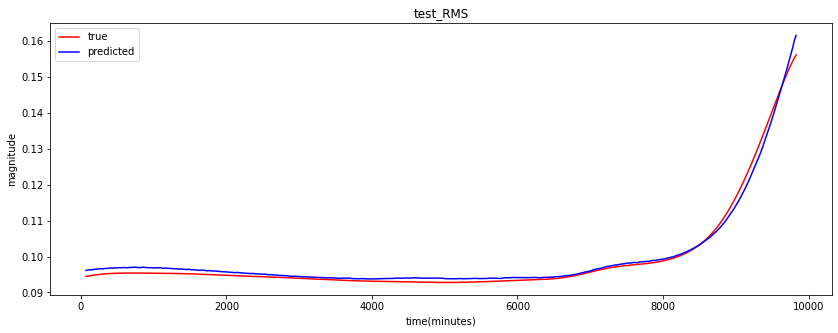

In [70]:
plt.figure(figsize=(14, 5))
plt.plot(np.array(time_stamp[test_past_features:len(test_smoothingdata)]),test_main_smoothingdata['test_RMS'][past_features:984],'r',label='true')
plt.plot(np.array(time_stamp[test_past_features:len(test_smoothingdata)]),test_transformed_data['test_RMS_predicted'],'b',label='predicted')
plt.legend(loc="upper left")
plt.ylabel('magnitude')
plt.xlabel('time(minutes)')
plt.title('test_RMS')
plt.show()

In [229]:
####ensembling

In [235]:
ensemble_train_inverse_data=pd.concat([pd.DataFrame(train_features[past_features:,0:3]),pd.DataFrame(prediction)],axis=1)

In [236]:
ensemble_train_transformed_data = le.inverse_transform(ensemble_train_inverse_data)
ensemble_train_transformed_data =pd.DataFrame(ensemble_train_transformed_data)

In [237]:
ensemble_train_transformed_data.columns=['Max','Std','Kurtosis','RMS_predicted']

In [238]:
from sklearn.metrics import mean_squared_error
import math
trainScore = math.sqrt(mean_squared_error(main_smoothingdata['RMS'][past_features:885],ensemble_train_transformed_data['RMS_predicted']) )
print('ensemble_Train Score: %.2f RMSE' % (trainScore))

ensemble_Train Score: 0.02 RMSE


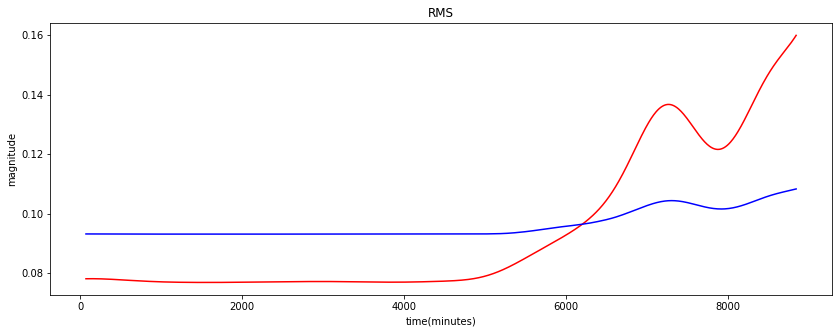

In [239]:
plt.figure(figsize=(14, 5))
plt.plot(np.array(time_stamp[past_features:len(train)]),main_smoothingdata['RMS'][past_features:885],'r')
plt.plot(np.array(time_stamp[past_features:len(train)]),ensemble_train_transformed_data['RMS_predicted'],'b')
plt.ylabel('magnitude')
plt.xlabel('time(minutes)')
plt.title('RMS')
plt.show()

In [240]:
####model1

In [261]:
RNN_train_prediction=model3.predict(x_train)
RNN_validation_prediction=model3.predict(x_validation)



RNN_train_inverse_data=pd.concat([pd.DataFrame(train_features[past_features:,0:3]),pd.DataFrame(RNN_train_prediction)],axis=1)
RNN_validation_inverse_data=pd.concat([pd.DataFrame(validation_features[past_features:,0:3]),pd.DataFrame(RNN_validation_prediction)],axis=1)

RNN_train_transformed_data = le.inverse_transform(RNN_train_inverse_data)
RNN_train_transformed_data =pd.DataFrame(RNN_train_transformed_data)
RNN_validation_transformed_data = le.inverse_transform(RNN_validation_inverse_data)
RNN_validation_transformed_data =pd.DataFrame(RNN_validation_transformed_data)

RNN_train_transformed_data.columns=['Max','Std','Kurtosis','RMS_predicted']
RNN_validation_transformed_data.columns=['Max','Std','Kurtosis','RMS_predicted']



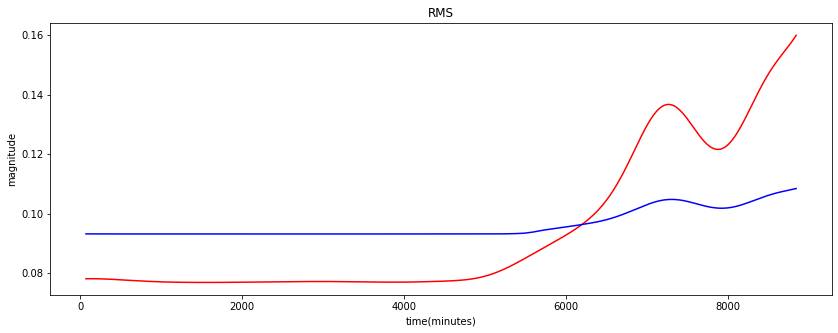

In [262]:
plt.figure(figsize=(14, 5))
plt.plot(np.array(time_stamp[past_features:len(train)]),main_smoothingdata['RMS'][past_features:885],'r')
plt.plot(np.array(time_stamp[past_features:len(train)]),RNN_train_transformed_data['RMS_predicted'],'b')
plt.ylabel('magnitude')
plt.xlabel('time(minutes)')
plt.title('RMS')
plt.show()

In [72]:
 from sklearn.kernel_ridge import KernelRidge

In [80]:
krr = KernelRidge(alpha=1.0)
krr.fit(np.arange(n).reshape(-1,1), estimator4)

KernelRidge(alpha=1.0)

In [84]:
predict=krr.predict(np.arange(n).reshape(-1,1))

In [83]:
estimator4

,0
0,0.078083
1,0.078095
2,0.078107
3,0.078118
4,0.078127
...,...
979,0.361148
980,0.365749
981,0.370397
982,0.375090


In [85]:
validationScore = math.sqrt(mean_squared_error(estimator4,predict ))
print('Validation Score: %.4f RMSE' % (validationScore))

Validation Score: 0.0400 RMSE


KeyError: (slice(None, None, None), None)

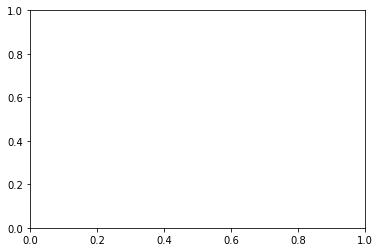

In [89]:
plt.plot(np.arange(n).reshape(-1,1),estimator4)

In [90]:
estimator4

,0
0,0.078083
1,0.078095
2,0.078107
3,0.078118
4,0.078127
...,...
979,0.361148
980,0.365749
981,0.370397
982,0.375090


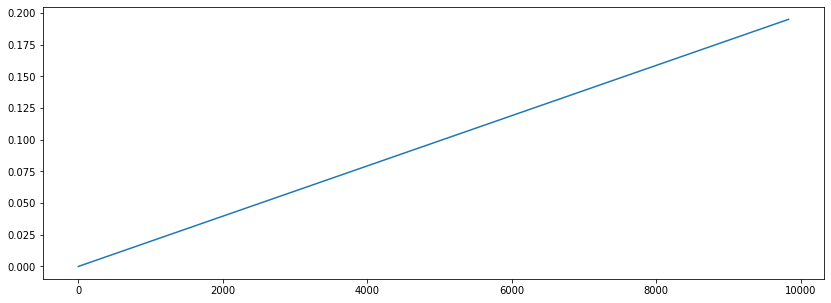

In [103]:
plt.figure(figsize=(14, 5))
plt.plot(np.array(time_stamp),np.array(predict))


In [99]:
np.array(estimator4)

array([[0.07808256],
       [0.07809543],
       [0.07810719],
       [0.07811785],
       [0.07812745],
       [0.07813599],
       [0.07814351],
       [0.07815002],
       [0.07815554],
       [0.07816011],
       [0.07816373],
       [0.07816643],
       [0.07816825],
       [0.07816918],
       [0.07816927],
       [0.07816853],
       [0.07816699],
       [0.07816466],
       [0.07816158],
       [0.07815776],
       [0.07815322],
       [0.07814799],
       [0.0781421 ],
       [0.07813555],
       [0.07812839],
       [0.07812062],
       [0.07811227],
       [0.07810337],
       [0.07809393],
       [0.07808397],
       [0.07807353],
       [0.07806262],
       [0.07805125],
       [0.07803947],
       [0.07802727],
       [0.07801469],
       [0.07800175],
       [0.07798846],
       [0.07797485],
       [0.07796094],
       [0.07794674],
       [0.07793228],
       [0.07791757],
       [0.07790264],
       [0.0778875 ],
       [0.07787217],
       [0.07785666],
       [0.077

In [108]:
x_train=np.array(smoothingdata)[:,0:3]

In [111]:
y_train=np.array(smoothingdata)[:,3]

In [113]:
y_train.shape

(984,)

In [114]:
krr.fit(x_train,y_train)

KernelRidge(alpha=1.0)

In [115]:
train_predict=krr.predict(x_train)

In [122]:
train_predict_pd=pd.DataFrame(train_predict)

In [125]:
total_predict=pd.concat([pd.DataFrame(x_train),train_predict_pd],axis=1)

In [126]:
total_predict

,0,1,2,0
0,0.020436,0.003726,0.047248,0.013942
1,0.019879,0.003774,0.046340,0.013681
2,0.019338,0.003819,0.045454,0.013426
3,0.018812,0.003859,0.044591,0.013176
4,0.018300,0.003896,0.043751,0.012932
...,...,...,...,...
979,0.915251,0.938369,0.897584,0.959880
980,0.935929,0.953549,0.922254,0.978501
981,0.956948,0.968884,0.947547,0.997395
982,0.978306,0.984370,0.973462,1.016556


In [127]:
train_predict_transform= le.inverse_transform(total_predict)

In [133]:
train_predict_transform[:,3]

array([0.09368007, 0.09366352, 0.09364733, 0.09363148, 0.09361598,
       0.09360081, 0.09358598, 0.09357147, 0.09355729, 0.09354342,
       0.09352987, 0.09351663, 0.09350369, 0.09349105, 0.0934787 ,
       0.09346664, 0.09345486, 0.09344336, 0.09343213, 0.09342117,
       0.09341047, 0.09340002, 0.09338983, 0.09337988, 0.09337017,
       0.0933607 , 0.09335145, 0.09334243, 0.09333363, 0.09332505,
       0.09331667, 0.0933085 , 0.09330052, 0.09329274, 0.09328515,
       0.09327774, 0.0932705 , 0.09326345, 0.09325656, 0.09324984,
       0.09324327, 0.09323686, 0.0932306 , 0.09322449, 0.09321852,
       0.09321268, 0.09320698, 0.09320141, 0.09319596, 0.09319063,
       0.09318542, 0.09318032, 0.09317533, 0.09317044, 0.09316566,
       0.09316097, 0.09315638, 0.09315187, 0.09314745, 0.09314312,
       0.09313886, 0.09313468, 0.09313058, 0.09312654, 0.09312257,
       0.09311867, 0.09311483, 0.09311104, 0.09310731, 0.09310364,
       0.09310001, 0.09309643, 0.0930929 , 0.0930894 , 0.09308

In [129]:
estimator4

,0
0,0.078083
1,0.078095
2,0.078107
3,0.078118
4,0.078127
...,...
979,0.361148
980,0.365749
981,0.370397
982,0.375090


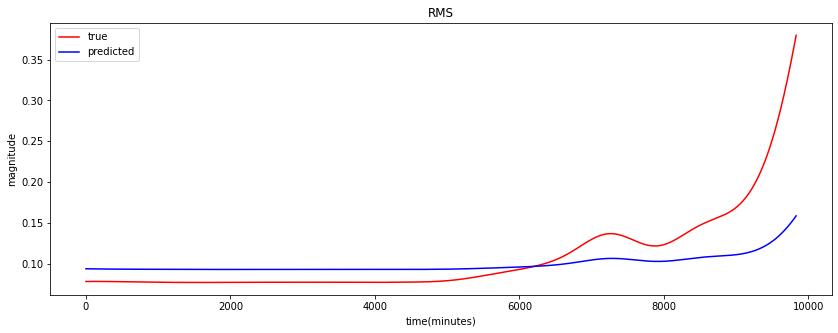

In [135]:
plt.figure(figsize=(14, 5))
plt.plot(np.array(time_stamp),np.array(estimator4),'r',label='true')
plt.plot(np.array(time_stamp),train_predict_transform[:,3],'b',label='predicted')
plt.legend(loc='upper left')
plt.ylabel('magnitude')
plt.xlabel('time(minutes)')
plt.title('RMS')
plt.show()

In [136]:
trainScore = math.sqrt(mean_squared_error(np.array(estimator4),train_predict_transform[:,3]) )
print('Train Score: %.4f RMSE' % (trainScore))

Train Score: 0.0421 RMSE


In [142]:
test_predict=krr.predict(np.array(test_smoothingdata)[:,0:3])

In [144]:
test_predict_pd=pd.DataFrame(test_predict)

In [145]:
total_test_predict=pd.concat([test_smoothingdata.iloc[:,0:3],test_predict_pd],axis=1)

In [147]:
total_test_transform_predict=le.inverse_transform(total_test_predict)

In [148]:
total_test_transform_predict

array([[0.47576684, 0.09407524, 0.50645808, 0.09965627],
       [0.47543971, 0.09412514, 0.2526961 , 0.09918057],
       [0.47512451, 0.09417385, 0.31046592, 0.09927793],
       ...,
       [0.63942633, 0.15533894, 0.        , 0.15298046],
       [0.64200051, 0.15569284, 0.        , 0.15348373],
       [0.64457985, 0.15603279, 0.        , 0.15397959]])

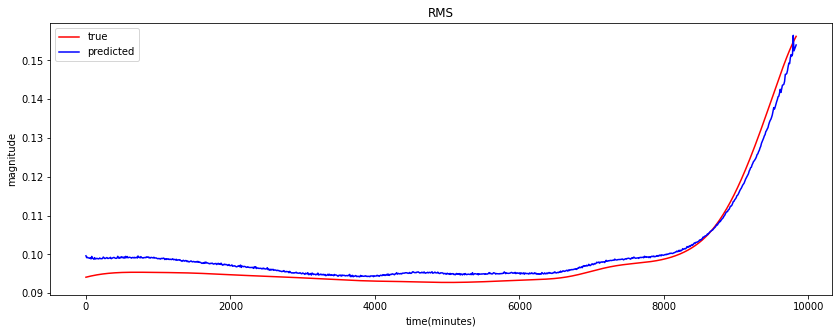

In [151]:
plt.figure(figsize=(14, 5))
plt.plot(np.array(time_stamp),np.array(test_estimator4),'r',label='true')
plt.plot(np.array(time_stamp),total_test_transform_predict[:,3],'b',label='predicted')
plt.legend(loc='upper left')
plt.ylabel('magnitude')
plt.xlabel('time(minutes)')
plt.title('RMS')
plt.show()

In [155]:
test_smoothingdata

,0,1,2,3
0,0.174379,0.020391,0.354552,0.021252
1,0.172779,0.021180,0.270374,0.022004
2,0.171237,0.021950,0.289537,0.022737
3,0.169753,0.022701,0.264512,0.023453
4,0.168326,0.023434,0.261516,0.024151
...,...,...,...,...
979,0.949725,0.977219,1.000000,0.976893
980,0.962239,0.983224,0.186549,0.982974
981,0.974795,0.989029,0.186549,0.988859
982,0.987385,0.994625,0.186549,0.994538
